### Ideias

* Podemos ter uma segunda avaliação com peso de acordo com os trendings e seus direcionamentos para sentimento... ele pode aumentar ou diminuir o peso do sentimento...
* Vamos usar comitês para tentar melhorar?
* Trending tentaremos obter palavras dos ngrams? E incluí-las? Além do tratamento de trending e sentimento
* We highly recommend the twokenize tokenizer from Allen Ritter’s work (https://github.com/aritter/twitter_nlp/blob/master/python/twokenize.py)

In [15]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
import re,string,unicodedata
from collections import Counter

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns



from sklearn.feature_extraction.text import TfidfVectorizer

## Inicializações

#### NLTK

In [26]:
nltk.download()
nltk.download('stopwords')

lista_stopwords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
lista_stopwords.update(punctuation)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
ARQUIVO_GLOVE_100 = 'glove.6B.100d.txt'
ARQUIVO_GLOVE_100_TWITTER = 'glove.twitter.27B.100d.txt'

In [6]:
#dados = pd.read_csv('Corona_NLP_train.csv')


In [7]:
# lista_sentimentos = dados.Sentiment.unique()
#lista_sentimentos.sort()
#lista_sentimentos

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

## Funções

#### Utilitários

In [28]:
# Carrega o arquivo de Embeddings
def read_embedding(file_name):
    with open(file_name,'r', encoding="utf8") as f:
        word_vocab = {} 
        word2vector = []
        pos = 0
        for line in f:
            line_ = line.strip() 
            words_vec = line_.split()
            
            if (len(words_vec) == 101):
                word_vocab[words_vec[0]] = pos
                word2vector.append(np.array(words_vec[1:],dtype=float)) 
                pos+=1
            
    word2vector = np.stack(word2vector)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [29]:
# separa tokens por representação vetorial
def split_tokens_word_vec(texto, vocab):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        
    todos_tokens = [token for token in tokenizer.tokenize(texto) if token not in lista_stopwords]
    tokens_encontrados = []
    tokens_nao_encontrados = []
    for token in todos_tokens:
        if token.lower() in vocab:
            tokens_encontrados.append(token.lower())
        else:
            tokens_nao_encontrados.append(token)
    return tokens_encontrados, tokens_nao_encontrados
        
        

#### Limpeza dos Dados

In [30]:
def limpa_texto(texto):
    # link
    texto = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', texto)
    # numero string com números não estamos retirando inicialmente (COVID-19)
    texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto

In [31]:
# retorna a matriz label para rnn
def get_labels_dict(lista_sentimentos):
    ret = {}
    for pos,sentimento in enumerate(lista_sentimentos):
        ret[sentimento] = pos
    return ret
    

In [32]:
labels_matrix_rnn(lista_sentimentos)

NameError: name 'labels_matrix_rnn' is not defined

---

## Pré-Processamento

#### Glove Não Twitter

Total Words in DataSet: 400000


#### Glove Twitter

### Rotina Pré-Processamento (Representação Vetorial/Contexto)

In [38]:
def carrega_tokens_word_vec(lista_tweet, vocab):
    feature_tokens = []
    feature_tokens_verificar =[]
    for tweet in lista_tweet:
        texto_limpo = limpa_texto(tweet)
        tokens_add, tokens_verify = split_tokens_word_vec(texto_limpo, vocab)
        feature_tokens.append(tokens_add)
        feature_tokens_verificar.append(tokens_verify)
        
    feature_tokens = np.asarray(feature_tokens)
    feature_tokens_verificar = np.asarray(feature_tokens_verificar)
    
    return feature_tokens, feature_tokens_verificar

In [34]:
def pre_processamento_word_vec(dados, glove_twitter=True):
    arquivo_glove = ARQUIVO_GLOVE_100_TWITTER
    if glove_twitter == False:
        arquivo_glove = ARQUIVO_GLOVE_100
    
    lista_tweet = dados.OriginalTweet
    labels_str = dados.Sentiment
    lista_sentimentos = dados.Sentiment.unique()
    
    vocab, embedding = read_embedding(arquivo_glove)
    
    lista_sentimentos.sort()
    labels_dict = get_labels_dict(lista_sentimentos)
    
    feature_tokens, feature_tokens_verificar = carrega_tokens_word_vec(lista_tweet, vocab)
    
    return (vocab, embedding), (feature_tokens, feature_tokens_verificar), labels_str, labels_dict
    
    

## Análise dos Dados

In [ ]:
print(len(dados))
print(dados.shape)

In [ ]:
dados.Sentiment.value_counts()

In [ ]:
dados.value_counts(['Location','Sentiment'])

In [ ]:
dados.isnull().sum()

In [ ]:
dados[['OriginalTweet','Sentiment']].head(10)

## Word Cloud

In [43]:
# Wordcloud
def monta_wordcloud(lista_topicos, texto_ou_frequencia, generate_from_text=True):
    num_topicos = len(lista_topicos)
    ncols = 2
    col = 0
    lin  = 1

    fig, ax = plt.subplots(1, ncols, figsize=(30, 20))

    for topico in lista_topicos:
        if generate_from_text:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate(texto_ou_frequencia[topico])
        else:
            wordcloud = WordCloud(background_color="black",collocations=False,
                              colormap="Oranges_r",
                              width = 1000,
                              height = 1000,
                              max_font_size=1000,
                              max_words=30
                             ).generate_from_frequencies(texto_ou_frequencia[topico])
    
        ax[col].imshow(wordcloud) 
        ax[col].set_title(f"{topico}")
        # No axis details
        ax[col].axis("off");
        col = col + 1
        if col >= ncols:
            plt.show()
            lin = lin + 1
            col = 0
            ax_cols =  ncols
            fig, ax = plt.subplots(1, ax_cols, figsize=(30, 20))   

In [39]:
_, _, feature_tokens, labels, _, _, labels_dict = monta_estrutura_execucao_rnn(split=False)

Total Words in DataSet: 1193513


### Word Cloud por Sentimento

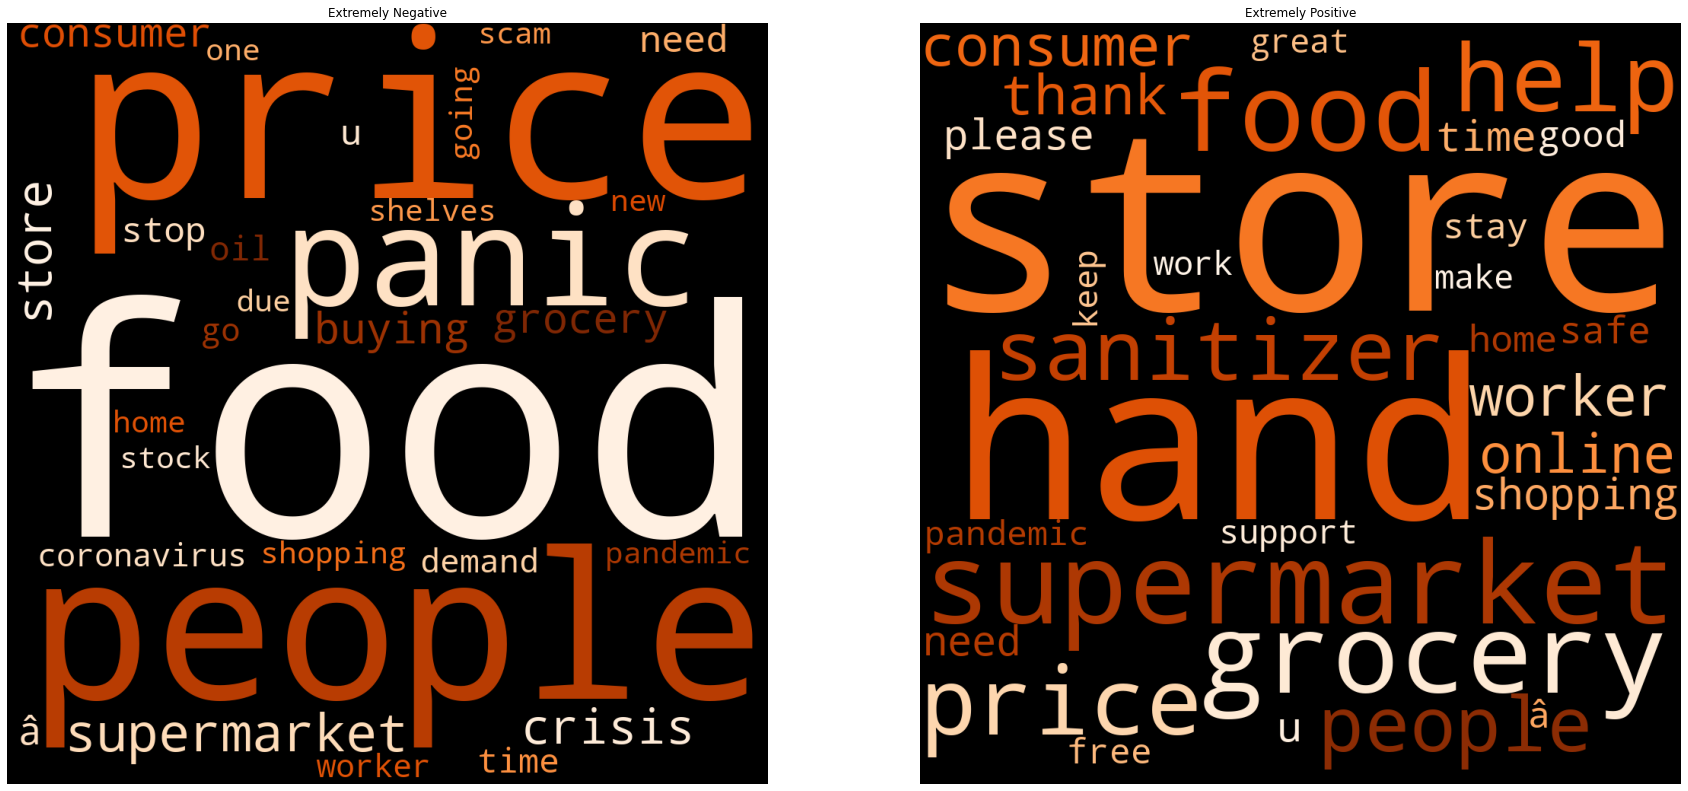

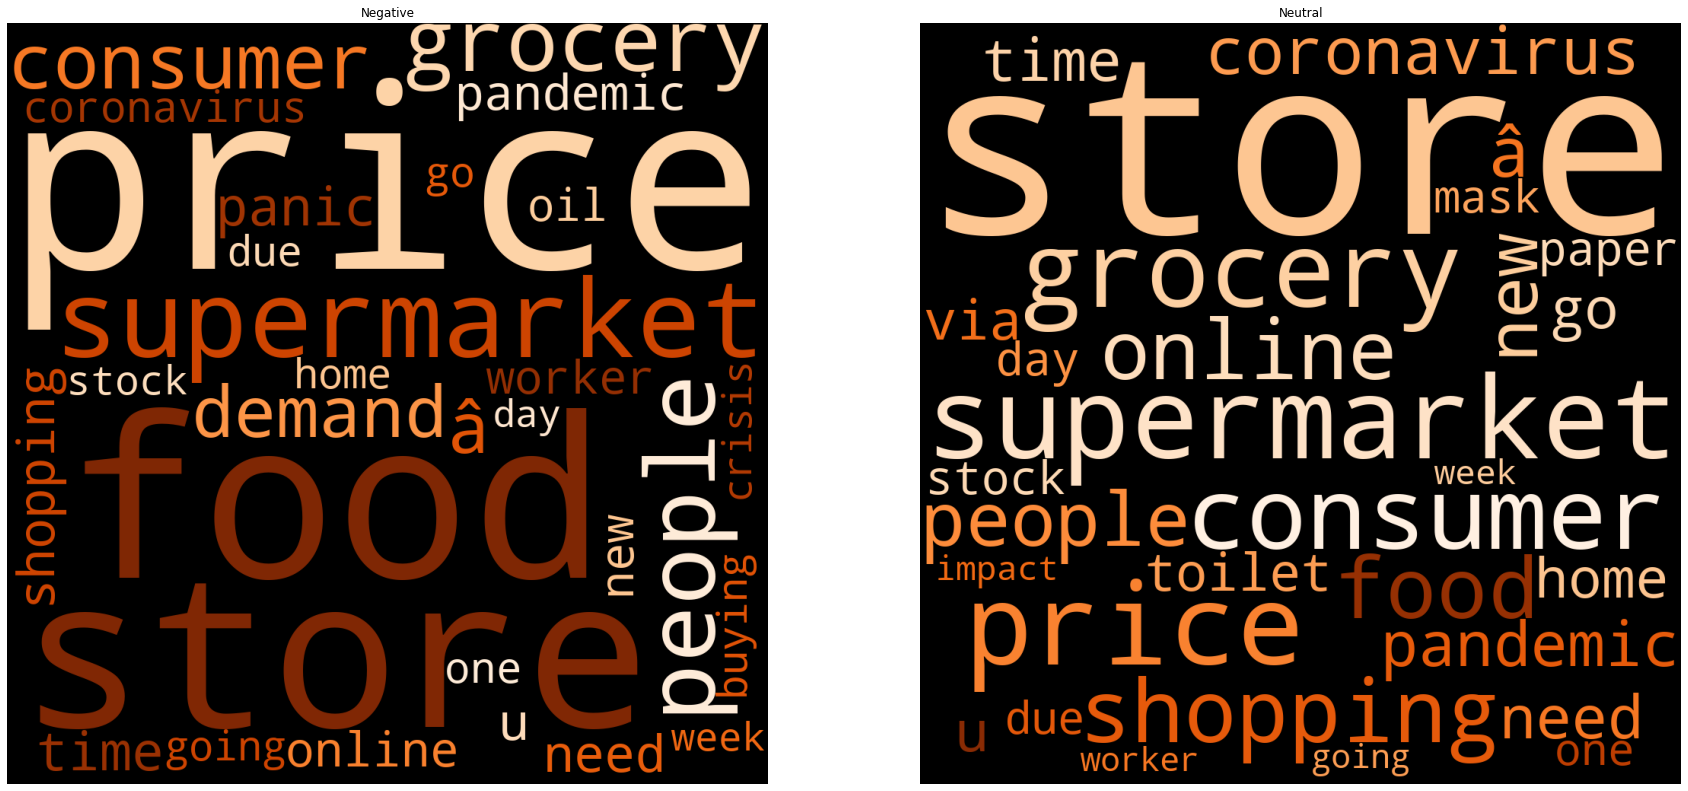

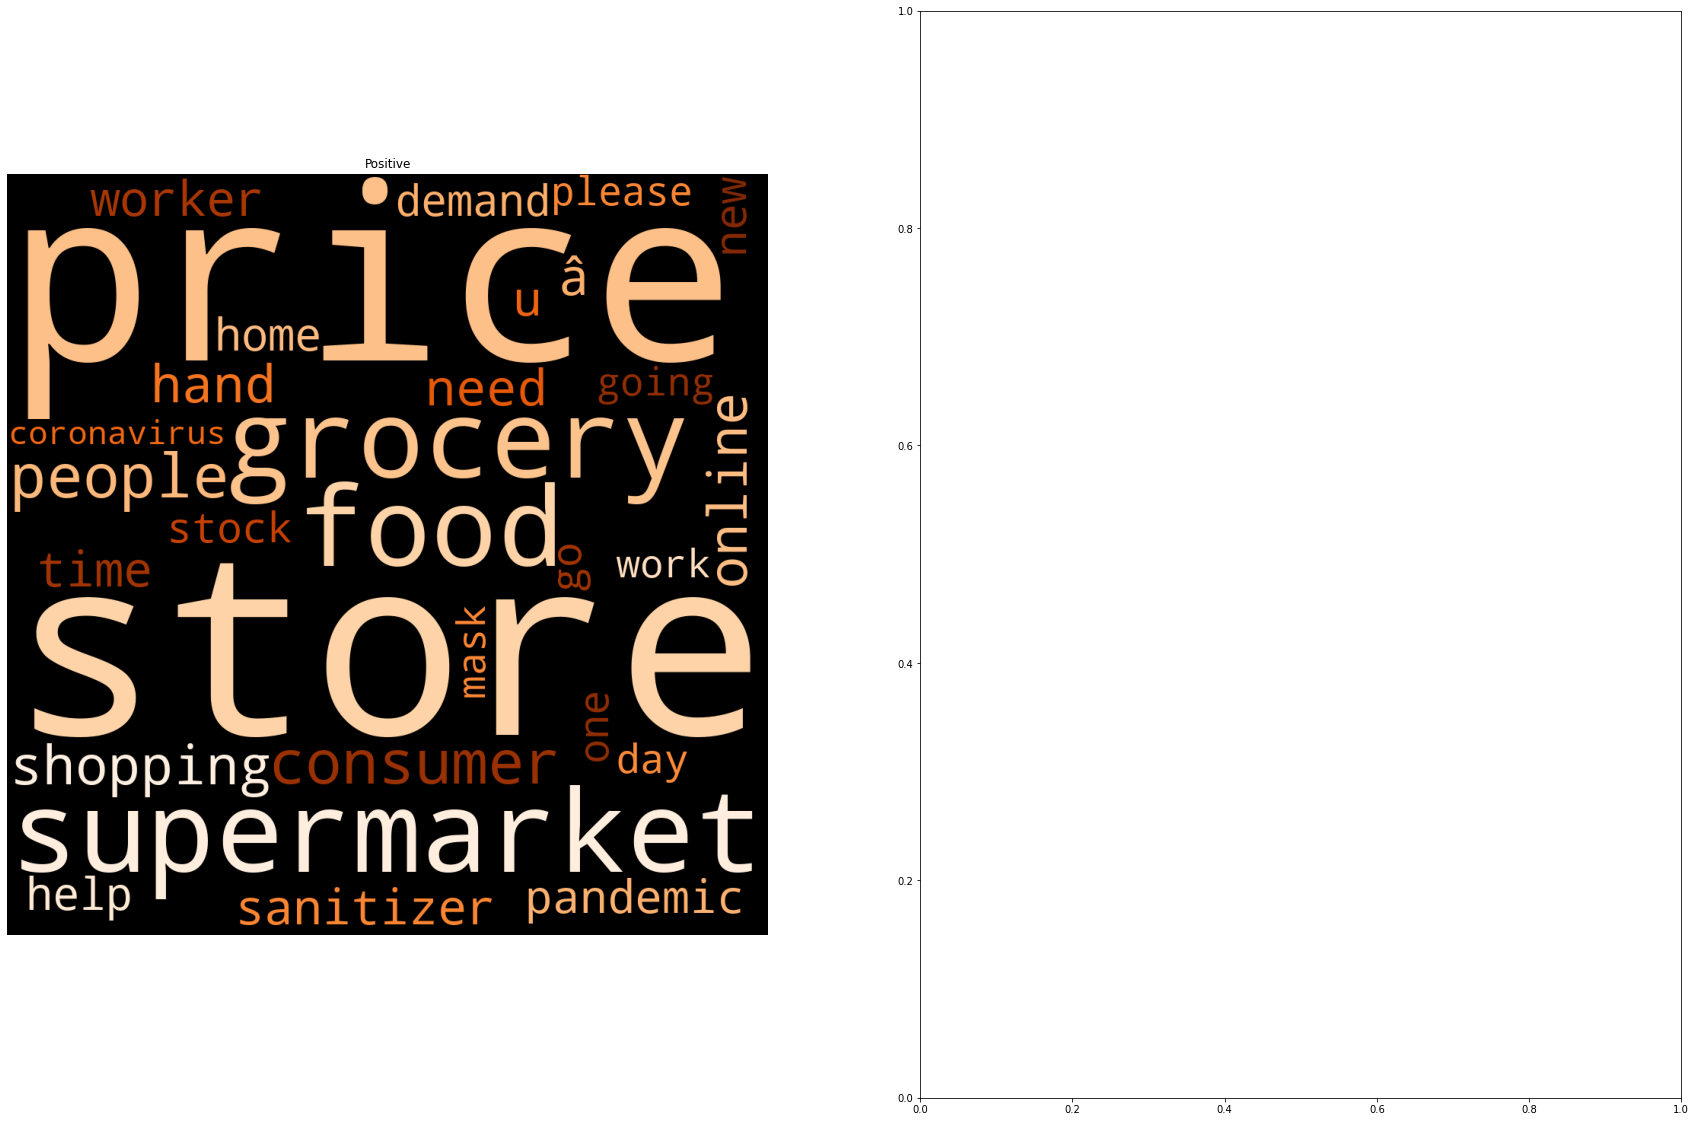

In [44]:
text_sentimento = {}
for sentimento in labels_dict:
    text_sentimento[sentimento] = " ".join([token for index, f_token in enumerate(feature_tokens) if labels[index] == sentimento for token in f_token ])  
monta_wordcloud(labels_dict, text_sentimento)

### Word Cloud por Trending/Sentimento

In [ ]:
_count_trends = Counter()
_count_trends.update([token for index, lista_token in enumerate(X_tokens + X_tokens_verificar) if y[index] == sentimento for token in lista_token if re.match(r'#\w+',token) ])
monta_wordcloud(lista_sentimentos, _count_trends, generate_from_text=False)


### Word Cloud palavras não Encontradas (Sem Trending)

In [ ]:
text_sentimento = " ".join([token for index, lista_token in enumerate(X_tokens_verificar) if y[index] == sentimento for token in lista_token if not re.match(r'#\w+',token)])
monta_wordcloud(lista_sentimentos, text_sentimento)


## Limpeza e Pré-Processamento

* @ e # não são separadores de tokens, verificar
* Podemos ter duas palavras juntas com ou sem capital, mas já podemos adiantar aquelas que tem capital na primeira letra
* Tratar palavras não encontradas para saber se tem duas palavras juntas e separá-las
* Tratamento diferenciado de Trendings para suporte ao resultado final
* Retirar URL's (Pratical NLP tem a referencia)
* Remover caracteres de ênfase.. yessssss sshhhhh... Expressão regular tweet_text = re.sub( r'(.)\ 1 +', r'\ 1\ 1', tweet_text)
* Correção de texto? Antresting viraria interesting (TextBlob faz isso com método correct)


In [10]:


tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
s0tw = tknzr.tokenize(s0)
print(s0tw)

tknzr = TweetTokenizer( reduce_len=True)
s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
s1tw = tknzr.tokenize(s1)
print(s1tw)

s0t = word_tokenize(s0)
s1t = word_tokenize(s1)
print(s0t)
print(s1t)


['This', 'is', 'a', 'coool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
['@remy', ':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
['This', 'is', 'a', 'cooool', '#', 'dummysmiley', ':', ':', '-', ')', ':', '-P', '<', '3', 'and', 'some', 'arrows', '<', '>', '-', '>', '<', '--']
['@', 'remy', ':', 'This', 'is', 'waaaaayyyy', 'too', 'much', 'for', 'you', '!', '!', '!', '!', '!', '!']


## Modelos

### LSTM

In [164]:
def create_model_LSTM(weight_matrix, dim_embedding, max_words_length):
    model = Sequential()
    model.add(Embedding(len(weight_matrix), dim_embedding, weights=[weight_matrix], input_length=max_words_length, trainable=False))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(5, activation='softmax'))
    # Adam Optimiser
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    return model

# Execução

In [21]:
# Converter tokens para a representação word vec
pre_processamento_word_vec
def convert_feature_tokens_to_word_vec(feature_tokens,  vocab, dimension_size=100, max_word_length=50):
    feature_word_vec = np.zeros((len(feature_tokens), max_word_length), dtype='int32')
    for c_feature, f_token in enumerate(feature_tokens):
        for c_token,token in enumerate(f_token):
            feature_word_vec[c_feature,c_token] = vocab[token]
        
    return feature_word_vec

# Converter labels da representação textual para one hot encode
def convert_labels_to_hot_encode(labels, label_dict):
    labels_conv =[label_dict[label] for label in labels]
    return pd.get_dummies(labels_conv).to_numpy()
    

In [24]:
def monta_estrutura_execucao_rnn(split=True):
    dados = pd.read_csv('Corona_NLP_train.csv', engine="python")
    (vocab, embedding), (feature_tokens, features_tokens_verificar) , labels, labels_dict = pre_processamento_word_vec(dados, glove_twitter=True)
    
    if split:
        feature_tokens_train, feature_tokens_validation, labels_train, labels_validation = train_test_split(feature_tokens, labels,  test_size=0.2, random_state=0)
    else:
        feature_tokens_train = feature_tokens
        labels_train = labels
        feature_tokens_validation = None
        labels_validation = None
        
    return vocab, embedding, feature_tokens_train, labels_train, feature_tokens_validation, labels_validation,  labels_dict
    

In [8]:
def executa_desafio(tipo_modelo):
    
    vocab, embedding, feature_tokens_train, labels_train, feature_tokens_validation, labels_validation,  labels_dict = monta_estrutura_execucao_rnn()
    
    y_train = convert_labels_to_hot_encode(labels_train, labels_dict)
    X_train = convert_feature_tokens_to_word_vec(feature_tokens_train, vocab)
    
    y_validation = convert_labels_to_hot_encode(labels_validation, labels_dict)
    X_validation = convert_feature_tokens_to_word_vec(feature_tokens_validation, vocab)
    
    if tipo_modelo == 'LSTM':
        model = create_model_LSTM(embedding, 100, 50)
        model.fit(train_X, train_y, batch_size=2000, epochs=100)
    
    

In [16]:
dados = pd.read_csv('Corona_NLP_train.csv')
lista_sentimentos = dados.Sentiment.unique()
lista_sentimentos.sort()
(vocab, embedding), (X_tokens, X_tokens_verificar), labels = pre_processamento(glove_twitter=True)
train_y = prepara_labels_rnn(labels, labels_dict)
train_X = prepara_tokens_rn(X_tokens, vocab)

Total Words in DataSet: 1193513


NameError: name 'carrega_tokens' is not defined

In [66]:
train_X_freq, train_y = pre_processamento_word_freq()

In [130]:
train_X_freq[0]

'TRENDING New Yorkers encounter empty supermarket shelves pictured Wegmans Brooklyn sold-out online grocers FoodKick MaxDelivery #coronavirus-fearing shoppers stock'

In [155]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', token_pattern=r'(?u)[\w#][\w-]*\b', max_df=0.8, min_df=10)
train_X_if_idf = vectorizer.fit_transform(train_X_freq).toarray()

In [156]:
fn = vectorizer.get_feature_names()

In [98]:
x = [s for s in fn if s == 'panicbuying']

In [184]:
train_y = prepara_labels_ml(y, labels_dict)
print(type(train_y))
y1 = train_y == 0
print(type(y1))
print(y1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ True False False ... False  True False]


### Mostra os termos mais relacionados com cada sentimento

In [159]:
train_X_if_idf.shape

(3798, 1561)

In [ ]:
for linha in train_X_if_idf:
    for c,s in enumerate(linha):
        if s > 0:
            print(fn[c])
    print('--------------')

In [119]:
x1.shape

(3798, 1513)

In [124]:
x2 = [i for i in linha if i > .0 for linha in x1]

(1, 1513)
(1, 1513)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

model_name
LinearSVC                 0.401002
LogisticRegression        0.398636
MultinomialNB             0.361243
RandomForestClassifier    0.287784
Name: accuracy, dtype: float64

## Execução Modelos Machine Learning

In [49]:
train_X_if_idf.shape

(3798, 3084)

# 'Extremely Negative':
  . Most correlated unigrams:
. hell
. crisis
. panic
  . Most correlated bigrams:
. emergency food
. stop panic
. panic buying
  . Most correlated trigrams:
. 
# 'Extremely Positive':
  . Most correlated unigrams:
. concerned
. drive
. netflix
  . Most correlated bigrams:
. stock prices
. sick days
. stock due
  . Most correlated trigrams:
. 
# 'Negative':
  . Most correlated unigrams:
. carts
. handling
. officially
  . Most correlated bigrams:
. panic buy
. fargo committed
. people going
  . Most correlated trigrams:
. 
# 'Neutral':
  . Most correlated unigrams:
. wegmans
. premium
. toiletpaperapocalypse
  . Most correlated bigrams:
. go hungry
. buy food
. still available
  . Most correlated trigrams:
. 
# 'Positive':
  . Most correlated unigrams:
. clients
. welcome
. purchases
  . Most correlated bigrams:
. inflated prices
. help covid_
. regular prices
  . Most correlated trigrams:
. 


model_name
LinearSVC                 0.398101
LogisticRegression        0.403635
MultinomialNB             0.350983
RandomForestClassifier    0.294105
Name: accuracy, dtype: float64

NameError: name 'sns' is not defined

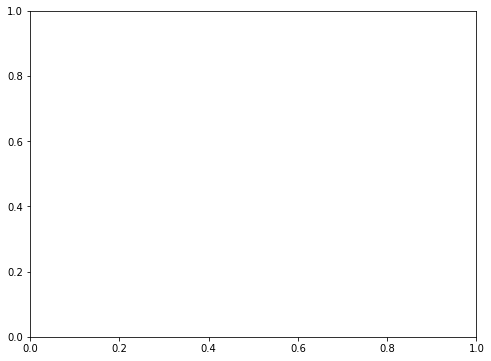

In [245]:
X_test.shape

(1254, 3063)

In [10]:
dados.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [12]:
dados.sort_values('TweetAt',ascending=False)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3797,3798,48750,"Arlington, Virginia",16-03-2020,I and @ForestandPaper members are committed to...,Extremely Positive
3487,3488,48440,Canada,16-03-2020,Almost out of parmesan cheese &amp; cat treats...,Negative
3475,3476,48428,London,16-03-2020,I hear online delivery slots for supermarkets ...,Extremely Positive
3476,3477,48429,"-25.992566, 27.986270",16-03-2020,Amazon delivery infrastructure strained as COV...,Negative
3477,3478,48430,"NYC, NY",16-03-2020,3. Open Q after COVID-19 of what happens to bl...,Extremely Negative
...,...,...,...,...,...,...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative


In [27]:
(vocab, embedding), (X_tokens, X_tokens_verificar) , labels = pre_processamento(glove_twitter=False)

Total Words in DataSet: 400000
